Business Problem: 
It is up to you to define a stakeholder and business problem appropriate to this dataset.

If you are struggling to define a stakeholder, we recommend you complete a project for a real estate agency that helps homeowners buy and/or sell homes. A business problem you could focus on for this stakeholder is the need to provide advice to homeowners about how home renovations might increase the estimated value of their homes, and by what amount.

Idea: Start by determining which factors matter. Run tests with ~95% confidence intervals, reject null hypotheses when it is appropriate to do so.

Rubric:
https://github.com/learn-co-curriculum/dsc-mod-2-project-v2-1/blob/master/mod2_project_rubric.pdf

Instructions:
https://docs.google.com/document/d/1N7h3-653wXl0BRC59MIMuURyDFX-DVw0uba6P6N7dzw/edit#
https://github.com/learn-co-curriculum/dsc-project-submissions-online

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import json
import requests
import time
from bs4 import BeautifulSoup
import re
from numpy.random import normal
import warnings
from scipy.stats import kurtosis, skew
import math
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

In [11]:
df_data=pd.read_csv('kc_house_data.csv')

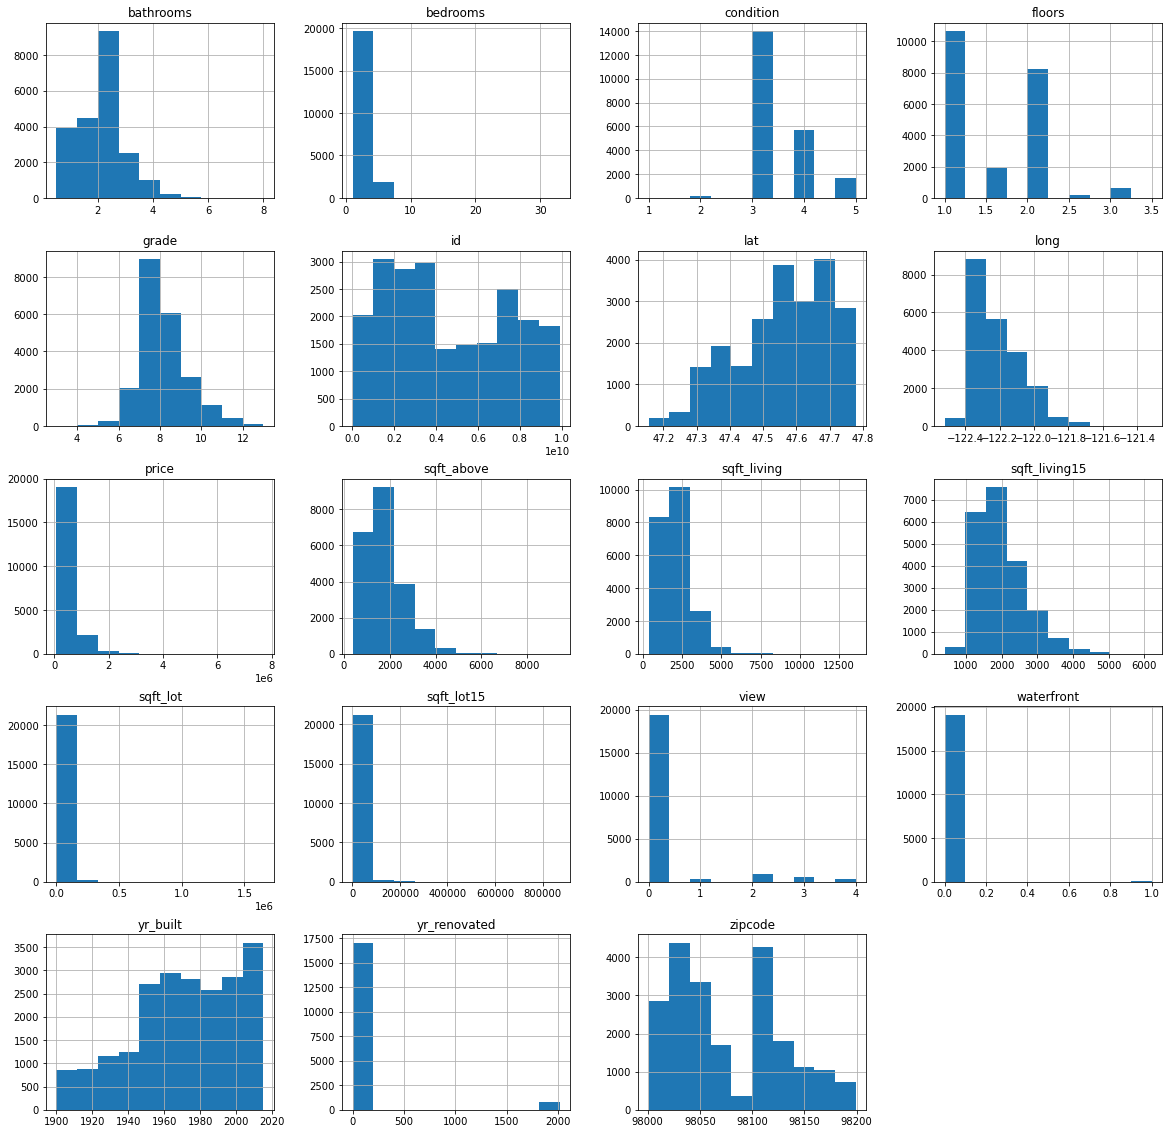

In [85]:
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
df_data.hist(ax = ax);

First, let's see if we can make any conclusions from the Condition variable, which is one of the categorical ones.

In [14]:
df_data.sort_values(['price','sqft_living'], ascending=[False, False]).head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,7700000.0,6,8.0,12050,27600,2.5,0.0,3.0,...,13,8570,3480.0,1910,1987.0,98102,47.6298,-122.323,3940,8800
3910,9808700762,6/11/2014,7060000.0,5,4.5,10040,37325,2.0,1.0,2.0,...,11,7680,2360.0,1940,2001.0,98004,47.6500,-122.214,3930,25449


In [15]:
df_data.condition.min()

1

In [16]:
df_data.condition.max()

5

In [17]:
df_data.condition.mean()

3.4098254387183404

In [18]:
print(df_data['condition'].describe())

count    21597.000000
mean         3.409825
std          0.650546
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64


In [19]:
print(df_data['condition'].nunique())

5


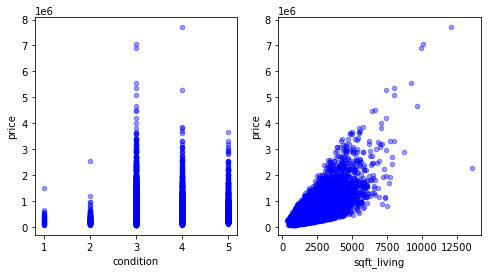

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

for xcol, ax in zip(['condition','sqft_living'], axes):
    df_data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

We can see that homes are given a rating of 1-5 depending on how good their condition is. 5 is the best condition, while 1 is the worst. The average home has a rating of 3.41. Do the houses' conditions from our dataset make a difference when determining their final value? Let's observe this further by isolating the houses with condition ratings of 5. 

In [86]:
df_data_good_condition = df_data.loc[df_data.condition == 5]
df_data_good_condition.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
3,2487200875,12/9/2014,604000.0,4,3.0,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
25,1202000200,11/3/2014,233000.0,3,2.0,1710,4697,1.5,0.0,0.0,...,6,1710,0.0,1941,0.0,98002,47.3048,-122.218,1030,4705


In [87]:
df_data.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [88]:
df_data_good_condition.price.describe()
#It is helpful to note that sample size of homes with good condition is 1,701.

count    1.701000e+03
mean     6.125777e+05
std      4.113179e+05
min      1.100000e+05
25%      3.500000e+05
50%      5.260000e+05
75%      7.250000e+05
max      3.650000e+06
Name: price, dtype: float64

In [24]:
df_data.sqft_living.mean()

2080.3218502569803

In [25]:
df_data_good_condition.sqft_living.mean()

2022.9112286890065

We can see that on average, the homes with condition scores of 5 are more valuable. But, is that difference statistically significant? We now have the information to make that determination.

In [26]:
#Good (5) condition mean (price): $612,578
#Population mean (price): $540,297
#Population standard deviation: $367,368
#Sample size: 1,701

In [27]:
numerator_condition=612578-540297
numerator_condition

72281

In [28]:
denominator_condition=367368/(1701)**.5
denominator_condition

8907.363322246227

In [29]:
z_score_condition=numerator_condition/denominator_condition
z_score_condition

8.114747022778053

##### Despite the fact that on average, houses with condition ratings of 5 or higher have slightly less square feet, we can conclude with 95% confidence that they are more valuable. Our z-score is 8.11, which is far more than we needed to make this conclusion. It is worth noting that we arrived at this z-score without removing outliers. Outliers tend to increase the standard deviation, meaning they make it less likely that we would reject a null hypothesis. As a result, condition is a variable we will want to include in our model. Let's investigate the number of floors using a similar process.

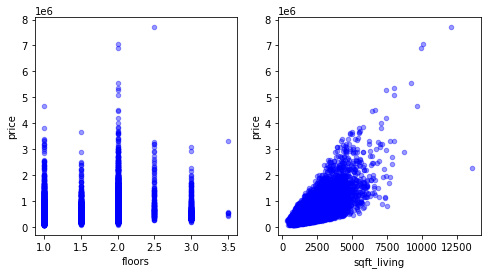

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

for xcol, ax in zip(['floors','sqft_living'], axes):
    df_data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

1.5 is very close to the middle of the pack in terms of number of floors. It is a bit hard to tell from our scatter plot, but it looks like there are more valuable homes with 2 floors, even though there are less of them. Let's see a quick correlation matrix consisting of our dependent variable (price), floors, and sqft_living (which we're already nearly certain has a positive impact on price).

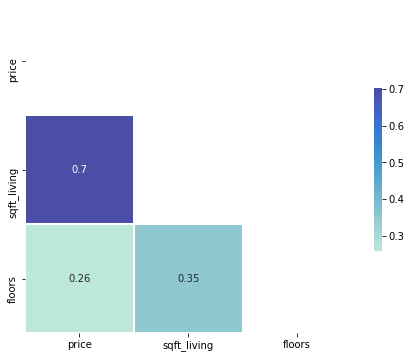

In [92]:
corr = df_data[['price','sqft_living','floors']].corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, center=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

This matrix leads us to believe that more floors generally means more value. (Also, as expected, the amount of square feet has a strong positive correlation with price.) Let's see if this difference is statistically significant.

In [32]:
df_data.sort_values(['price','floors'], ascending=[False, False]).head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,7700000.0,6,8.0,12050,27600,2.5,0.0,3.0,...,13,8570,3480.0,1910,1987.0,98102,47.6298,-122.323,3940,8800
3910,9808700762,6/11/2014,7060000.0,5,4.5,10040,37325,2.0,1.0,2.0,...,11,7680,2360.0,1940,2001.0,98004,47.6500,-122.214,3930,25449


In [33]:
df_data.floors.min()

1.0

In [34]:
df_data.floors.max()

3.5

In [35]:
df_data.floors.mean()

1.4940964022780943

In [36]:
df_data.floors.median()

1.5

In [37]:
df_data.floors.describe()

count    21597.000000
mean         1.494096
std          0.539683
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

In [38]:
#Creating a dataframe consisting of all homes with 2 or more floors.
df_data_2_floors = df_data.loc[df_data.floors >= 2]

In [39]:
df_data_2_floors.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,9.014000e+03,9.014000e+03,9014.000000,9014.000000,9014.000000,9.014000e+03,9014.000000,8047.000000,8988.000000,9014.000000,9014.000000,9014.000000,9014.000000,7454.000000,9014.000000,9014.000000,9014.000000,9014.000000,9014.000000
mean,4.661544e+09,6.522873e+05,3.594520,2.618926,2528.556690,1.535844e+04,2.077879,0.009569,0.254450,3.182938,8.356778,2359.651653,1991.151542,81.979340,98068.895607,47.558777,-122.176562,2281.322720,12940.896716
std,2.921332e+09,4.441065e+05,0.861994,0.630352,990.224943,4.426575e+04,0.260650,0.097357,0.807296,0.466013,1.143465,876.972931,24.559948,396.254237,46.559114,0.133722,0.147888,752.857321,30514.606033
min,1.000102e+06,9.000000e+04,1.000000,0.500000,550.000000,5.720000e+02,2.000000,0.000000,0.000000,1.000000,5.000000,550.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.133010e+09,3.800000e+05,3.000000,2.500000,1810.000000,4.066000e+03,2.000000,0.000000,0.000000,3.000000,8.000000,1730.000000,1987.000000,0.000000,98032.000000,47.479325,-122.304000,1690.000000,4314.000000
50%,3.905100e+09,5.400000e+05,4.000000,2.500000,2390.000000,6.633500e+03,2.000000,0.000000,0.000000,3.000000,8.000000,2260.000000,1999.000000,0.000000,98058.000000,47.574700,-122.182000,2190.000000,6600.000000
75%,7.504101e+09,7.700000e+05,4.000000,2.750000,3060.000000,1.030450e+04,2.000000,0.000000,0.000000,3.000000,9.000000,2860.000000,2006.000000,0.000000,98107.000000,47.667500,-122.056000,2750.000000,9920.000000
max,9.839301e+09,7.700000e+06,11.000000,8.000000,13540.000000,1.024068e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.359000,6210.000000,871200.000000


In [40]:
len(df_data_2_floors)

9014

In [41]:
df_data_2_floors.price.mean()

652287.3035278455

In [42]:
df_data.price.mean()

540296.5735055795

In [43]:
#2+ floors mean (price): $652,287
#Population mean (price): $540,297
#Population standard deviation: $367,368
#Sample size: 9,014

In [44]:
numerator_floors=652287-540297
denominator_floors=367368/(9014)**.5

In [93]:
z_score_floors=numerator_floors/denominator_floors

In [94]:
z_score_floors

28.94254369350173

It certainly seems as though the number of floors should be included in our final model, as they are statistically significant.

Now, before we do any transformations that relate to the distribution of data, let's make sure that our data is sufficient. Our data should be formatted so that it can be fed into a model.

In [12]:
df_data.price.isna().sum()

0

In [74]:
df_data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [ ]:
#yr_renovated: Change NaN to 0.
#waterfront: Change NaN to 0.
#view: Change NaN to 0.

In [99]:
df_data['yr_renovated'] = df_data['yr_renovated'].fillna(0)
df_data['waterfront'] = df_data['waterfront'].fillna(0)
df_data['view'] = df_data['view'].fillna(0)

In [100]:
df_data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [101]:
df_data.shape

(21597, 21)

In [102]:
df_data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

All columns are in numerical format (integers or floats) except for date and sqft_basement, which may be unnecessary because of the other metrics that relate to square feet. Regardless, we do not know enough yet to conclude that it will not be helpful in our model, so we will want to clean it up.

In [108]:
df_data['sqft_basement']=df_data['sqft_basement'].replace('?',0)

In [111]:
df_data['sqft_basement'] = df_data['sqft_basement'].astype(float)

In [112]:
df_data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [114]:
df_data.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639


In [116]:
pd.to_datetime(df_data['date'])

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21592   2014-05-21
21593   2015-02-23
21594   2014-06-23
21595   2015-01-16
21596   2014-10-15
Name: date, Length: 21597, dtype: datetime64[ns]

In [118]:
df_data['date']=pd.to_datetime(df_data['date'])

In [119]:
df_data.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront              float64
view                    float64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement           float64
yr_built                  int64
yr_renovated            float64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [47]:
#Note: .summary() and .pvalues can be very helpful. What can we do so that those functions work with our dataset?
#Note: Use R^2 and describe its formal definition.
#Note: Try to alter variables that are not statistically significant so that we can make them significant
#and include them. If we can't alter them so that they are statistically significant, remove them. We do not
#want those in our final model.
#Idea: two-sample t-test, comparing waterfront vs. no waterfront. If it turns out that waterfront
#makes sa significant difference, that could be a good reason to include in the linear regression.

Time to check for multicollinearity. If the independent variables in our model have high correlations with each other, that can lead to issues.

In [120]:
abs(df_data.corr())>0.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [121]:
df = df_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df['Pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['Pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)
df.columns = ['Correlation']
df.drop_duplicates(inplace=True)
df[(df.Correlation>.75) & (df.Correlation<1)]

,Correlation
Pairs,
"(sqft_above, sqft_living)",0.876448
"(sqft_living, grade)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(grade, sqft_above)",0.756073
"(sqft_living, bathrooms)",0.755758


We will need to decide which variables to remove from our model. Sqft_above, sqft_living15, and bathrooms could probably be removed from our model, as these both have a very high correlation with sqft_living. This small dataframe gives us some help. Let's run a regression and see where things stand as it is.

In [122]:
outcome='price'
x_cols=[col for col in df_data.columns]
x_cols.remove('price')
predictors='+'.join(x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df_data).fit()
model.summary()
#Investigate: Is being in a particular school district beneficial for price?

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     132.0
Date:                Mon, 16 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:48:27   Log-Likelihood:            -2.9411e+05
No. Observations:               21597   AIC:                         5.890e+05
Df Residuals:                   21207   BIC:                         5.921e+05
Df Model:                         389                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                  6.86e+06   2.94e+06      2.333      0.020     1.1e+06    1.26e+07
date[T.Timestamp('2014-05-03 00:00:00')]  1.756e+05   1.03e+05      1.702      0.089   -2.66e+04    3.78e+05
date[T.Timestamp('2014-05-04 00:00:00')] -6.548e+04   9.29e+04     -0.705      0.481   -2.48e+05    1.17e+05
date[T.Timestamp('2014-05-05 00:00:00')]  1.645e+04   3.28e+04      0.501      0.616   -4.79e+04    8.08e+04
date[T.Timestamp('2014-05-06 00:00:00')]  -149.1239   3.29e+04     -0.005      0.996   -6.47e+04    6.44e+04
date[T.Timestamp('2014-05-07 00:00:00')]  1.448e+04   3.21e+04      0.451      0.652   -4.85e+04    7.74e+04
date[T.Timestamp('2014-05-08 00:00:00')]  4.844e+04   3.31e+04      1.463      0.143   -1.65e+04    1.13e+05
date[T.Timestamp('2014-05-09 00:00:00')] -1.478e+04   3.31e+04     -0.447      0.655   -7.97e+04    5.01e+04
date[T.Timestamp('2014-05-10 00:00:00')]  3.117e+04    9.3e+04      0.335      0.737   -1.51e+05    2.13e+05
date[T.Timestamp('2014-05-11 00:00:00')]  6.345e+04   1.44e+05      0.441      0.659   -2.19e+05    3.45e+05
date[T.Timestamp('2014-05-12 00:00:00')]  2.123e+04   3.32e+04      0.639      0.523   -4.39e+04    8.63e+04
date[T.Timestamp('2014-05-13 00:00:00')]   4.62e+04   3.27e+04      1.414      0.157   -1.78e+04     1.1e+05
date[T.Timestamp('2014-05-14 00:00:00')]  8128.7981   3.31e+04      0.246      0.806   -5.68e+04     7.3e+04
date[T.Timestamp('2014-05-15 00:00:00')]  6927.0048    3.3e+04      0.210      0.834   -5.78e+04    7.16e+04
date[T.Timestamp('2014-05-16 00:00:00')]  1453.7636   3.39e+04      0.043      0.966    -6.5e+04    6.79e+04
date[T.Timestamp('2014-05-17 00:00:00')]  8.225e+04   2.02e+05      0.407      0.684   -3.14e+05    4.78e+05
date[T.Timestamp('2014-05-18 00:00:00')]  1.944e+04   7.96e+04      0.244      0.807   -1.37e+05    1.76e+05
date[T.Timestamp('2014-05-19 00:00:00')]  1.389e+04   3.29e+04      0.422      0.673   -5.07e+04    7.84e+04
date[T.Timestamp('2014-05-20 00:00:00')]  1.355e+04   3.08e+04      0.440      0.660   -4.67e+04    7.38e+04
date[T.Timestamp('2014-05-21 00:00:00')]  9844.5029   3.21e+04      0.307      0.759    -5.3e+04    7.27e+04
date[T.Timestamp('2014-05-22 00:00:00')]  1.089e+04   3.23e+04      0.338      0.736   -5.24e+04    7.42e+04
date[T.Timestamp('2014-05-23 00:00:00')]  1.244e+04   3.28e+04      0.379      0.705   -5.19e+04    7.68e+04
date[T.Timestamp('2014-05-24 00:00:00')]  5.713e+04   6.53e+04      0.875      0.381   -7.08e+04    1.85e+05
date[T.Timestamp('2014-05-25 00:00:00')] -8.848e+04   9.29e+04     -0.952      0.341   -2.71e+05    9.37e+04
date[T.Timestamp('2014-05-26 00:00:00')] -1.648e+04    7.5e+04     -0.220      0.826   -1.63e+05     1.3e+05
date[T.Timestamp('2014-05-27 00

There is a lot to clean here. Our initial findings, however, appear to confirm our belief that condition is an important categorical variable to include. We can already see that it has a p-value of 0.000 (statistically significant at a 95% confidence interval, no multicollinearity problems).

One issue is the skewness, which is 2.811 (heavily right-skewed). We can deal with this by removing outliers.

In [51]:
for i in range(90, 100):
    q = i / 100
    print('{} percentile: {}'.format(q, df_data['price'].quantile(q=q)))

0.9 percentile: 887000.0
0.91 percentile: 919993.6
0.92 percentile: 950000.0
0.93 percentile: 997964.0000000002
0.94 percentile: 1060000.0
0.95 percentile: 1160000.0
0.96 percentile: 1260000.0
0.97 percentile: 1390000.0
0.98 percentile: 1600000.0
0.99 percentile: 1970000.0


In [52]:
len(df_data)

21597

In [53]:
no_outliers=df_data[df_data['price']<=1260000]

In [54]:
len(no_outliers)

20742

Since our data is extremely right-skewed, it may be helpful to remove data with prices in the 96th percentile and above.

In [55]:
outcome='price'
x_cols=[col for col in no_outliers.columns]
x_cols.remove('price')
predictors='+'.join(x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=no_outliers).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     61.03
Date:                Mon, 16 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:15:24   Log-Likelihood:            -1.9788e+05
No. Observations:               15130   AIC:                         3.970e+05
Df Residuals:                   14487   BIC:                         4.019e+05
Df Model:                         642                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -3.927e+06   2.13e+06     -1.846      0.065    -8.1e+06    2.44e+05
date[T.1/12/2015]        8.328e+04    1.2e+05      0.693      0.489   -1.52e+05    3.19e+05
date[T.1/13/2015]        9.507e+04    1.2e+05      0.790      0.429   -1.41e+05    3.31e+05
date[T.1/14/2015]        7.286e+04    1.2e+05      0.609      0.543   -1.62e+05    3.08e+05
date[T.1/15/2015]        7.883e+04    1.2e+05      0.656      0.512   -1.57e+05    3.14e+05
date[T.1/16/2015]         6.53e+04    1.2e+05      0.544      0.586    -1.7e+05       3e+05
date[T.1/17/2015]        9.013e+04   1.68e+05      0.538      0.591   -2.39e+05    4.19e+05
date[T.1/19/2015]        1.826e+04   1.27e+05      0.144      0.885    -2.3e+05    2.66e+05
date[T.1/2/2015]         8.543e+04    1.2e+05      0.711      0.477    -1.5e+05    3.21e+05
date[T.1/20/2015]        1.181e+05    1.2e+05      0.983      0.326   -1.17e+05    3.54e+05
date[T.1/21/2015]        8.467e+04    1.2e+05      0.707      0.479    -1.5e+05    3.19e+05
date[T.1/22/2015]        1.067e+05    1.2e+05      0.889      0.374   -1.29e+05    3.42e+05
date[T.1/23/2015]        1.218e+05    1.2e+05      1.016      0.310   -1.13e+05    3.57e+05
date[T.1/24/2015]        2.344e+04   1.46e+05      0.161      0.872   -2.62e+05    3.09e+05
date[T.1/25/2015]            1e+05   1.45e+05      0.689      0.491   -1.85e+05    3.85e+05
date[T.1/26/2015]        1.062e+05    1.2e+05      0.884      0.376   -1.29e+05    3.41e+05
date[T.1/27/2015]        9.317e+04    1.2e+05      0.777      0.437   -1.42e+05    3.28e+05
date[T.1/28/2015]        8.568e+04    1.2e+05      0.716      0.474   -1.49e+05     3.2e+05
date[T.1/29/2015]        9.549e+04    1.2e+05      0.794      0.427    -1.4e+05    3.31e+05
date[T.1/30/2015]        1.201e+05   1.21e+05      0.990      0.322   -1.18e+05    3.58e+05
date[T.1/31/2015]          37.2940     21.762      1.714      0.087      -5.362      79.950
date[T.1/5/2015]         1.056e+05    1.2e+05      0.882      0.378   -1.29e+05     3.4e+05
date[T.1/6/2015]         1.033e+05    1.2e+05      0.858      0.391   -1.33e+05    3.39e+05
date[T.1/7/2015]         1.169e+05    1.2e+05      0.973      0.330   -1.19e+05    3.52e+05
date[T.1/8/2015]         6.102e+04    1.2e+05      0.508      0.612   -1.75e+05    2.97e+05
date[T.1/9/2015]         1.402e+05   1.21e+05      1.161      0.246   -9.66e+04    3.77e+05
date[T.10/1/2014]        1.327e+05   1.19e+05      1.112      0.266   -1.01e+05    3.67e+05
date[T.10/10/2014]        9.95e+04   1.19e+05      0.834      0.404   -1.34e+05    3.33e+05
date[T.10/11/2014]       8.987e+04   1.67e+05      0.537      0.591   -2.38e+05    4.18e+05
date[T.10/12/2014]       1.567e+05   1.45e+05      1.081      0.280   -1.27e+05    4.41e+05
date[T.10/13/2014]       9.311e+04    1.2e+05  

That solved our issue with the data being very skewed to the right.

We will also want to remove variables with p-values greater than 0.05, as these are statistically insignificant.

In [56]:
summary = model.summary()
p_table = summary.tables[1]
p_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.927e+06,2.13e+06,-1.846,0.065,-8.1e+06,2.44e+05
date[T.1/12/2015],8.328e+04,1.2e+05,0.693,0.489,-1.52e+05,3.19e+05
date[T.1/13/2015],9.507e+04,1.2e+05,0.790,0.429,-1.41e+05,3.31e+05
date[T.1/14/2015],7.286e+04,1.2e+05,0.609,0.543,-1.62e+05,3.08e+05
date[T.1/15/2015],7.883e+04,1.2e+05,0.656,0.512,-1.57e+05,3.14e+05
date[T.1/16/2015],6.53e+04,1.2e+05,0.544,0.586,-1.7e+05,3e+05
date[T.1/17/2015],9.013e+04,1.68e+05,0.538,0.591,-2.39e+05,4.19e+05
date[T.1/19/2015],1.826e+04,1.27e+05,0.144,0.885,-2.3e+05,2.66e+05
date[T.1/2/2015],8.543e+04,1.2e+05,0.711,0.477,-1.5e+05,3.21e+05
date[T.1/20/2015],1.181e+05,1.2e+05,0.983,0.326,-1.17e+05,3.54e+05


In [57]:
#Do not clear out the Intercept. If necessary, start with dropping .100 p-values so as to keep Intercept (.065).

In [58]:
p_table_df = pd.DataFrame(p_table.data)

In [59]:
p_table_df.columns=['column','coef','std err','t','P>|t|','0.025','0.975']

In [60]:
p_table_df.drop(labels=0,axis=0,inplace=True)

In [61]:
p_table_df.set_index('column',inplace=True)

In [62]:
p_table_df.head(3)

,coef,std err,t,P>|t|,0.025,0.975
column,,,,,,
Intercept,-3.927e+06,2.13e+06,-1.846,0.065,-8.1e+06,2.44e+05
date[T.1/12/2015],8.328e+04,1.2e+05,0.693,0.489,-1.52e+05,3.19e+05
date[T.1/13/2015],9.507e+04,1.2e+05,0.790,0.429,-1.41e+05,3.31e+05


In [63]:
p_table_df['P>|t|'] = p_table_df['P>|t|'].astype(float)

In [64]:
#Problem: If we drop everything with a p-value>.05, we would also drop our intercept. Is that acceptable?
#For now, limit it to below .07 so that we keep intercept.

In [65]:
p_table_df['pass07']=p_table_df['P>|t|'].map(lambda x: x<=.07)

In [66]:
p_table_df['pass07']

column
Intercept             True
date[T.1/12/2015]    False
date[T.1/13/2015]    False
date[T.1/14/2015]    False
date[T.1/15/2015]    False
                     ...  
zipcode               True
lat                   True
long                  True
sqft_living15         True
sqft_lot15            True
Name: pass07, Length: 662, dtype: bool

In [67]:
pass_list07=list(p_table_df[p_table_df['pass07']==True].index)

In [68]:
pass_list07

['Intercept',
 'date[T.11/30/2014]',
 'date[T.2/21/2015]',
 'date[T.4/4/2015]',
 'sqft_basement[T.100.0]',
 'sqft_basement[T.1024.0]',
 'sqft_basement[T.1110.0]',
 'sqft_basement[T.1160.0]',
 'sqft_basement[T.120.0]',
 'sqft_basement[T.1281.0]',
 'sqft_basement[T.1284.0]',
 'sqft_basement[T.1340.0]',
 'sqft_basement[T.1390.0]',
 'sqft_basement[T.140.0]',
 'sqft_basement[T.1430.0]',
 'sqft_basement[T.1560.0]',
 'sqft_basement[T.1570.0]',
 'sqft_basement[T.1620.0]',
 'sqft_basement[T.1640.0]',
 'sqft_basement[T.1660.0]',
 'sqft_basement[T.1700.0]',
 'sqft_basement[T.1730.0]',
 'sqft_basement[T.1770.0]',
 'sqft_basement[T.180.0]',
 'sqft_basement[T.1800.0]',
 'sqft_basement[T.1820.0]',
 'sqft_basement[T.1870.0]',
 'sqft_basement[T.1910.0]',
 'sqft_basement[T.1913.0]',
 'sqft_basement[T.1950.0]',
 'sqft_basement[T.200.0]',
 'sqft_basement[T.2060.0]',
 'sqft_basement[T.2070.0]',
 'sqft_basement[T.2090.0]',
 'sqft_basement[T.2100.0]',
 'sqft_basement[T.2110.0]',
 'sqft_basement[T.225.0]',
 '

In [69]:
outcome='price'
x_cols=pass_list
predictors='+'.join(x_cols)
formula=outcome+'~'+predictors
train, test = train_test_split(p_table_df)
model=ols(formula=formula,data=train).fit()
model.summary()

NameError: name 'pass_list' is not defined

In [70]:
p_table_df.head(2)

,coef,std err,t,P>|t|,0.025,0.975,pass07
column,,,,,,,
Intercept,-3.927e+06,2.13e+06,-1.846,0.065,-8.1e+06,2.44e+05,True
date[T.1/12/2015],8.328e+04,1.2e+05,0.693,0.489,-1.52e+05,3.19e+05,False


In [71]:
x_cols=x_cols.map(lambda x: x.replace('.','_'))

AttributeError: 'list' object has no attribute 'map'

In [72]:
pass_list

NameError: name 'pass_list' is not defined

In [ ]:
#Change . to _. Hyphens would also need to be changed.